In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import kornia
from torchview import draw_graph

#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class image_loader(torch.utils.data.Dataset):

    def __init__(self, batch_size, directory):
        super().__init__()
        self.image_dir = directory
        self.batch_size = batch_size
        self.directory = directory
        self.all_file_paths = [self.directory + file_name for file_name in os.listdir(self.directory)]
    
    def __len__(self):
        return len(os.listdir(self.directory))//self.batch_size

    def __getitem__(self, batch_number, training = False):
        
        image_numbers = range(batch_number * self.batch_size, (batch_number+1) * self.batch_size)

        batch_l_channel = torch.empty((0, 1, h_image_size, h_image_size))
        batch_ab_channels = torch.empty((0, 2, h_image_size, h_image_size))
        for image_number in image_numbers:

            image_l_channel, image_ab_channels = self.load_processed_image_channels(image_number, training)
            batch_l_channel = torch.cat((batch_l_channel, image_l_channel),0)
            batch_ab_channels = torch.cat((batch_ab_channels, image_ab_channels))

        return batch_l_channel, batch_ab_channels

    def load_processed_image_channels(self, image_number, training = False):

        image = torchvision.io.read_image(self.all_file_paths[image_number])
        
        image = torchvision.transforms.Resize(
                (h_image_size, h_image_size),
                antialias=None)(image)
        if training:
            image = torchvision.transforms.RandomHorizontalFlip()(image)
            image = torchvision.transforms.RandomVerticalFlip()(image)
        image = image = torch.unsqueeze(image,0)
        image = image/256
        image = kornia.color.rgb_to_lab(image)
        
        l_channel = torch.subtract(image[:,0,:,:],50)/50
        ab_channels = image[:,1:,:,:]/128
        
        return torch.unsqueeze(l_channel,0), ab_channels

    def load_unprocessed_image(self, image_number):
        
        image = torchvision.io.read_image(self.all_file_paths[image_number])
        image = torchvision.transforms.Resize(
                (h_image_size, h_image_size),
                antialias=None)(image)
        image = image.movedim(0,-1)
        return image

In [3]:
class Downsampling(nn.Module):

    def __init__(self, in_filters, out_filters):
        super().__init__()

        self.conv = nn.Conv2d(in_filters, out_filters,
                              kernel_size = 5, stride = 2 ,padding=2).to('cuda')
        self.res = nn.Conv2d(in_filters, out_filters,
                              kernel_size = 1, stride = 2).to('cuda')
        
        self.norm = nn.BatchNorm2d(out_filters).to('cuda')
        self.dropout = nn.Dropout(0.2).to('cuda')
        self.activation = nn.LeakyReLU(0.1).to('cuda')
        #self.pool = nn.AvgPool2d(2).to('cuda')

    def forward(self, x):
        #print(f'downbl {x.shape}')
        block = self.conv(x)
        #block = self.pool(block)
        block = self.norm(block)
        block = self.activation(block)
        block = self.dropout(block)
        res = self.res(x)
        block = torch.add(block, res)
        
        return block.to('cuda')

In [4]:
class Upsampling(nn.Module):

    def __init__(self, in_filters, out_filters):
        super().__init__()

        self.conv = nn.ConvTranspose2d(in_filters, out_filters, kernel_size = 4, stride = 2,
                                      padding=1).to('cuda')
        self.res = nn.ConvTranspose2d(in_filters, out_filters, kernel_size = 1, stride = 2,
                                     output_padding=1).to('cuda')
        
        self.norm = nn.BatchNorm2d(out_filters).to('cuda')
        self.dropout = nn.Dropout(0.2).to('cuda')
        self.activation = nn.LeakyReLU(0.1).to('cuda')

    def forward(self, x, skip):

        block = self.conv(x)

        block = self.norm(block)
        block = self.activation(block)
        block = self.dropout(block)
        res = self.res(x)
        block = torch.add(block, res)
        block = torch.cat((block, skip),1)
        
        return block.to('cuda')

In [5]:
class Generator(nn.Module):

    def __init__(self, image_size, max_filters):
        super().__init__()

        self.n_layers = int(np.floor(np.log2(image_size)))
        self.max_filters = max_filters
        
        self.input = nn.Conv2d(in_channels = 1,out_channels = 16, kernel_size = 5,
                               padding= 2).to('cuda')
        
        self.finalconv = nn.ConvTranspose2d(in_channels = 32, out_channels=2, kernel_size=1, stride=1).to('cuda')

        self.apply(self.__init_weights)

        # ==== Create Downsampling Stack ====
        
        self.downstack = []
        for layer in range(self.n_layers):
            if 2 ** (4+layer) < self.max_filters:
                self.downstack.append(Downsampling(in_filters=2 ** (4+layer),
                                                   out_filters=2 ** (5+layer)))
            else:
                self.downstack.append(Downsampling(in_filters=self.max_filters,
                                                   out_filters=self.max_filters))
                
        self.downstack = nn.ModuleList(self.downstack)   

        # ==== Initial Layer for Upsampling Stack ====
        
        if 2 ** (5+self.n_layers) > self.max_filters:
            self.upstack_init = [Upsampling(in_filters = self.max_filters, out_filters = self.max_filters)]
        else: 
            self.upstack_init = [Upsampling(in_filters = 2 ** (4+self.n_layers),
                                            out_filters = 2 ** (3+self.n_layers))]

        # ==== Create Remaining Upsampling Stack ====
        
        self.upstack = []
        for layer in range(self.n_layers-1):
            if 2**(self.n_layers - layer + 3) > self.max_filters:
                self.upstack.append(Upsampling(in_filters = 2 * self.max_filters,
                                                out_filters = self.max_filters))
            else:
                self.upstack.append(Upsampling(in_filters = 2**(self.n_layers - layer + 4),
                                                out_filters = 2**(self.n_layers - layer + 2)))
                
        self.upstack = nn.ModuleList(self.upstack_init + self.upstack)


    def __init_weights(self, module):

        if isinstance(module, nn.Conv2d):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.ConvTranspose2d):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    
    def forward(self, x):
        
        skips = []
        conv = self.input(x)
        skips.append(conv)
        np.ceil
        for x in self.downstack:
            skipconv = x(conv)
            skips.append(skipconv)
            conv = skips[-1]
            #print(conv.shape)
            
        for idx, layer in enumerate(self.upstack):
            conv = layer(conv, skips[-(idx+2)])
            #print(conv.shape)
        
        out = self.finalconv(conv)
        out = F.tanh(out)
        # print(out.size())
        #print(out.shape)
        return out

    def colorize(self, x):

        predictions = self.forward(x).detach()
        x_adj = torch.add(x*50,50).to(torch.long)
        predictions = (predictions * 128).to(torch.long)
        image = torch.cat((x_adj, predictions),1)    
        image = kornia.color.lab_to_rgb(torch.squeeze(image,0))
        image = image.movedim(0,-1)
        
        return image

In [6]:
h_epochs = 100
h_saves = 20
h_image_size = 32
h_max_allowable_filters = 128
h_batch_size = 500
h_train_dir = 'Train/'
h_test_dir = 'Test/'

In [7]:
generator = Generator(h_image_size, h_max_allowable_filters).to('cuda')
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
train_data_loader = image_loader(h_batch_size, h_train_dir)
test_data_loader = image_loader(1, h_test_dir)

saved_epochs = []
losses = []

In [8]:
#with torch.autograd.profiler.profile() as prof:
generator.train();
for epoch in tqdm(range(h_epochs)):
    for batch_number in range(len(train_data_loader)):

        
        a, b = train_data_loader.__getitem__(batch_number, training=True)
        a, b = a.to('cuda'), b.to('cuda')
        
        model_out = generator.forward(a)
        loss = F.mse_loss(model_out,b)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        losses.append(loss.to('cpu'))
        
    if not (epoch % h_epochs//h_saves):
        generator.eval()

        x, y = train_data_loader.load_processed_image_channels(42)
        x, y = x.to('cuda'), y.to('cuda')
        predictions = generator.colorize(x)
        saved_epochs.append(predictions.to('cpu').numpy())
        
        generator.train()

generator.eval();      
#print(prof.key_averages().table(sort_by="self_cpu_time_total"))
#torch.save(gen, 'gen.pth')

100%|█████████████████████████████████████████████████████| 100/100 [15:03<00:00,  9.04s/it]


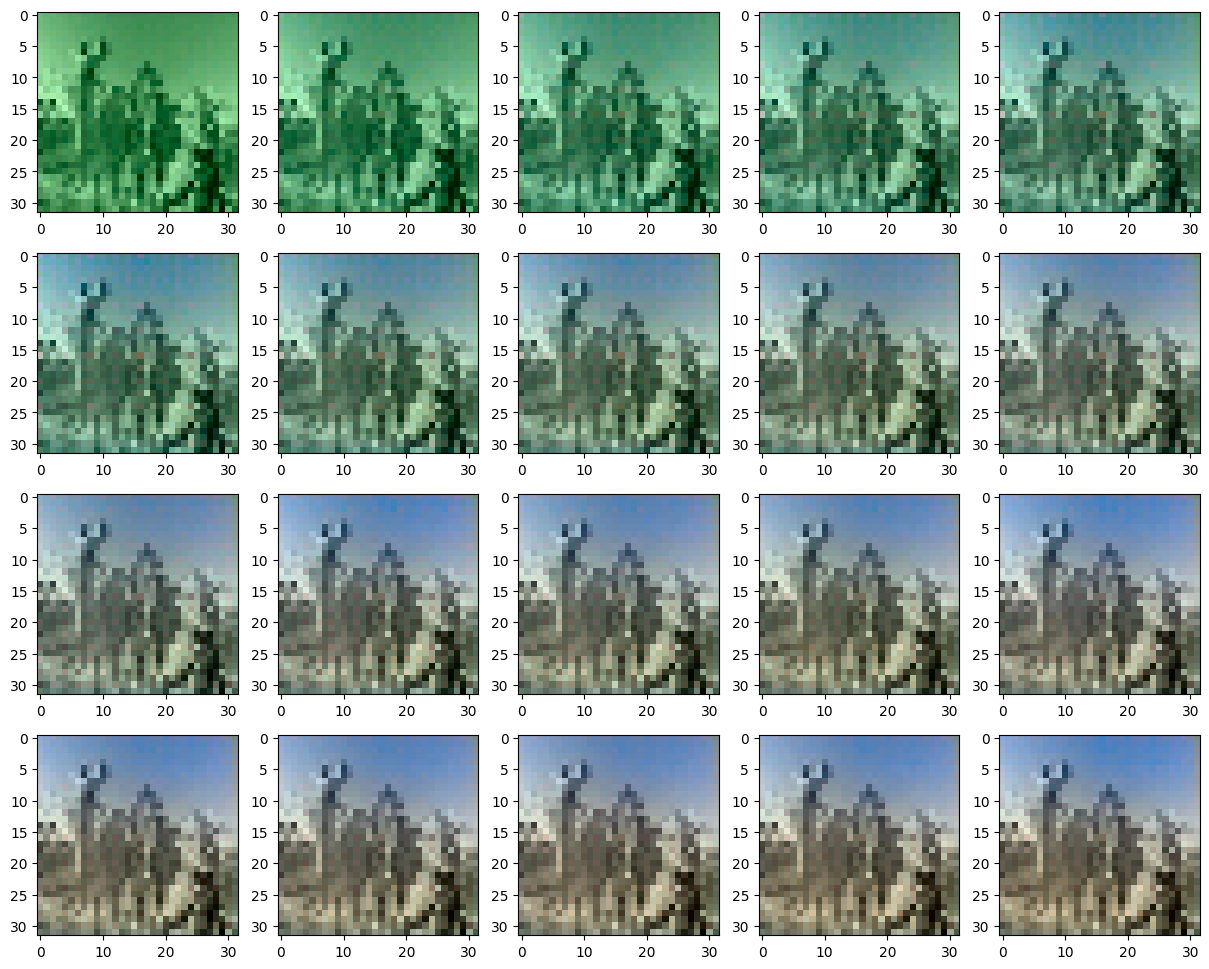

In [9]:
rows = (np.ceil(len(saved_epochs)/5)).astype(int)

if rows == 1:
    fig, ax = plt.subplots(1,5,figsize=(15,3))
    for index, axis in enumerate(ax):
        try:
            axis.imshow(saved_epochs[index])
        except:
            pass
else:
    fig, ax = plt.subplots(rows,5,figsize=(15,3*rows))
    for row_no, row in enumerate(ax):
        for index, axis in enumerate(row):
            try:
                axis.imshow(saved_epochs[index + 5* row_no])
            except:
                pass

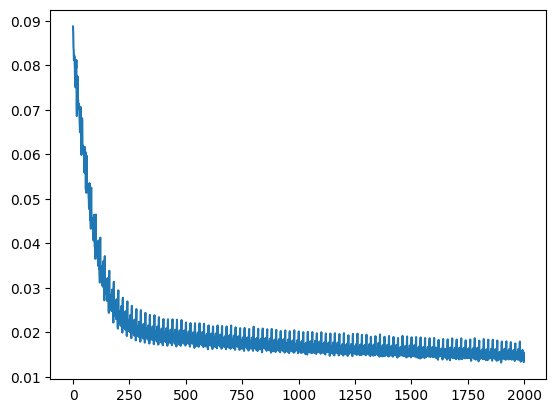

In [10]:
losses = [x.to('cpu').detach().numpy() for x in losses]
plt.plot(range(len(losses)),losses);

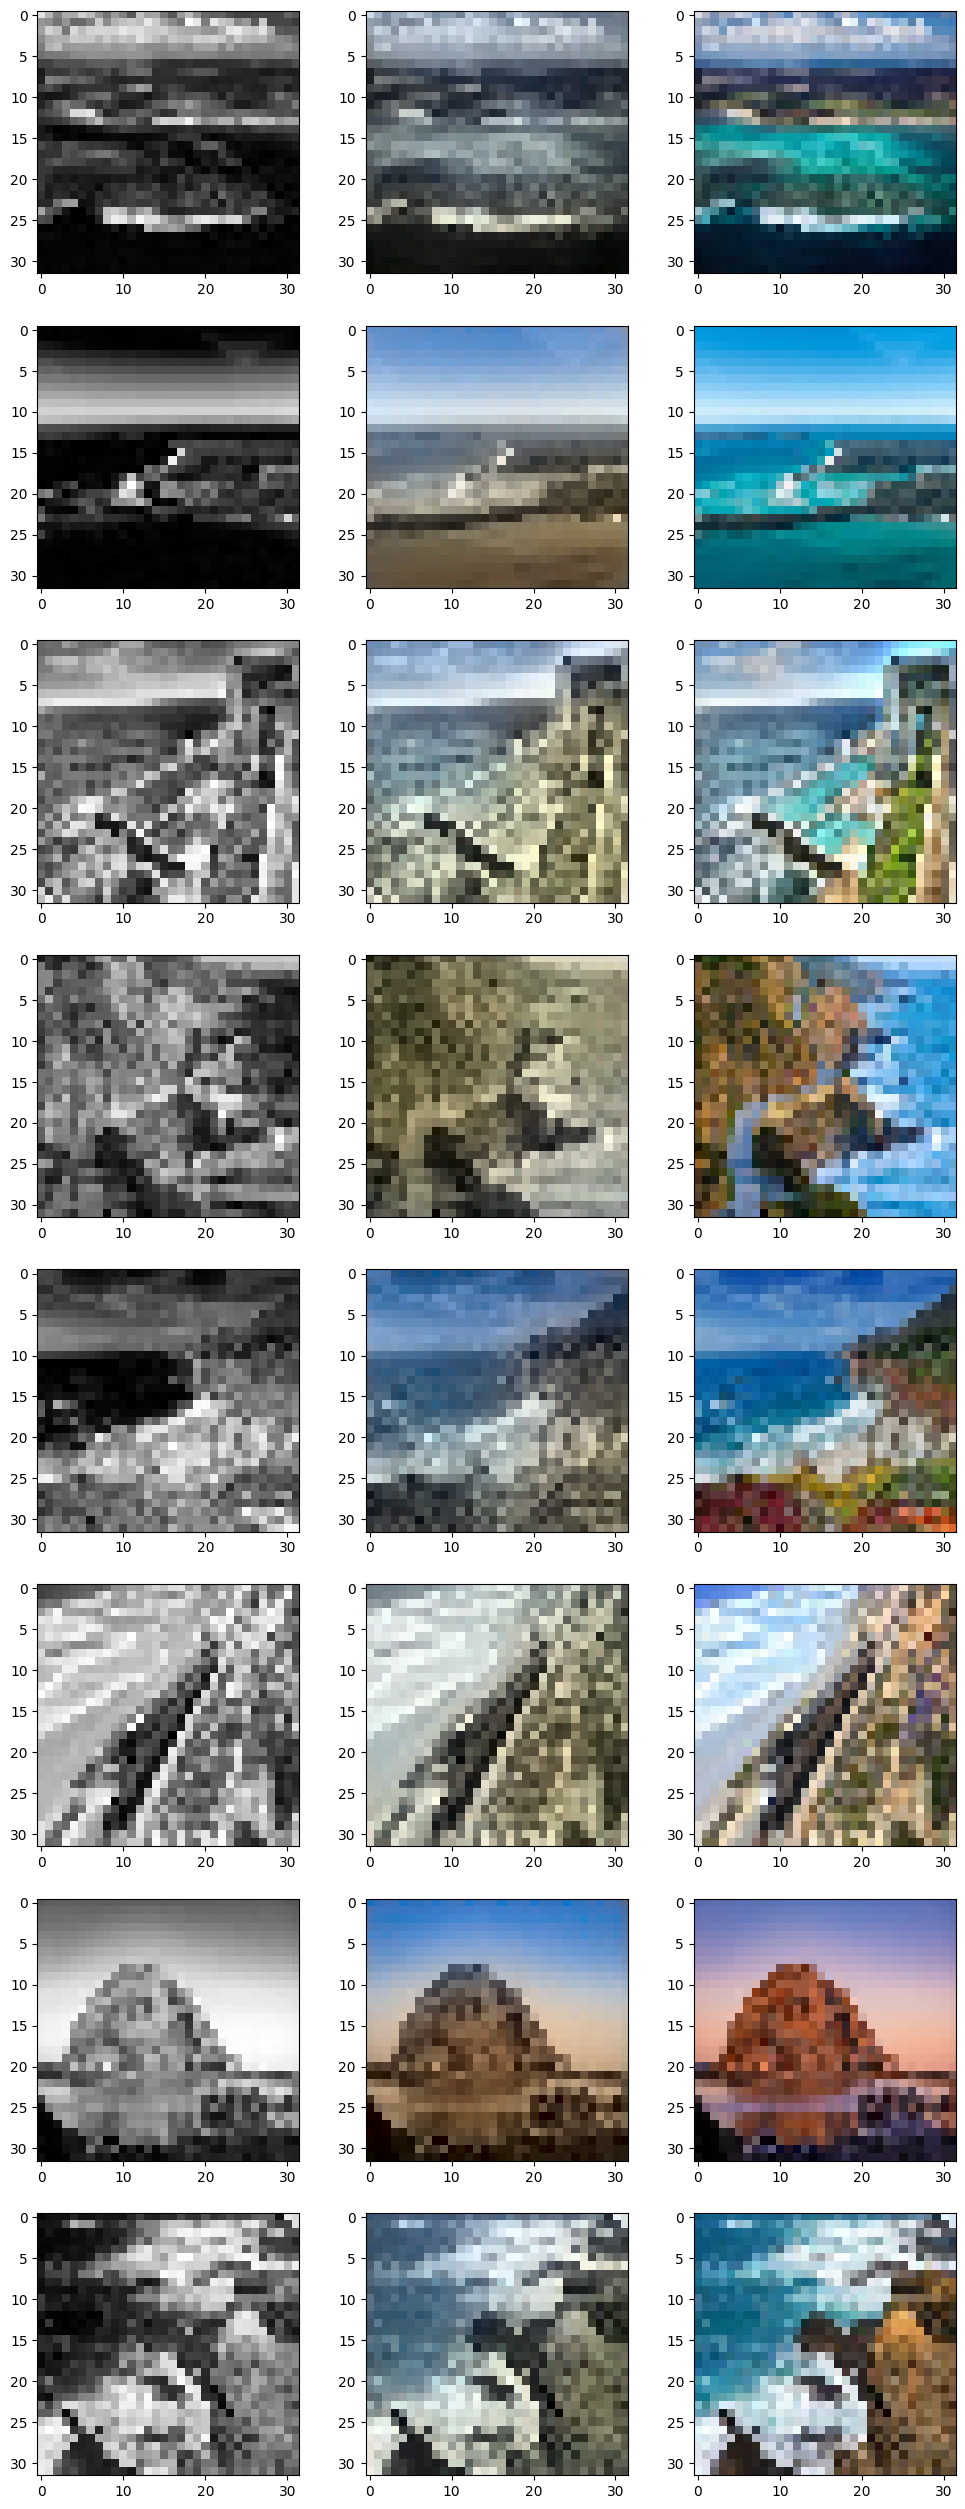

In [15]:
fig, ax = plt.subplots(8,3,figsize=(12,32))

for image_number in range(8):
    x, y = train_data_loader.load_processed_image_channels(image_number)
    x, y = x.to('cuda'), y.to('cuda')
    predictions = generator.colorize(x)
    ax[image_number][0].imshow(train_data_loader.load_unprocessed_image(
    image_number)[:,:,0], cmap='gray')
    
    ax[image_number][1].imshow(predictions.to('cpu').detach().numpy())
    
    ax[image_number][2].imshow(train_data_loader.load_unprocessed_image(image_number))

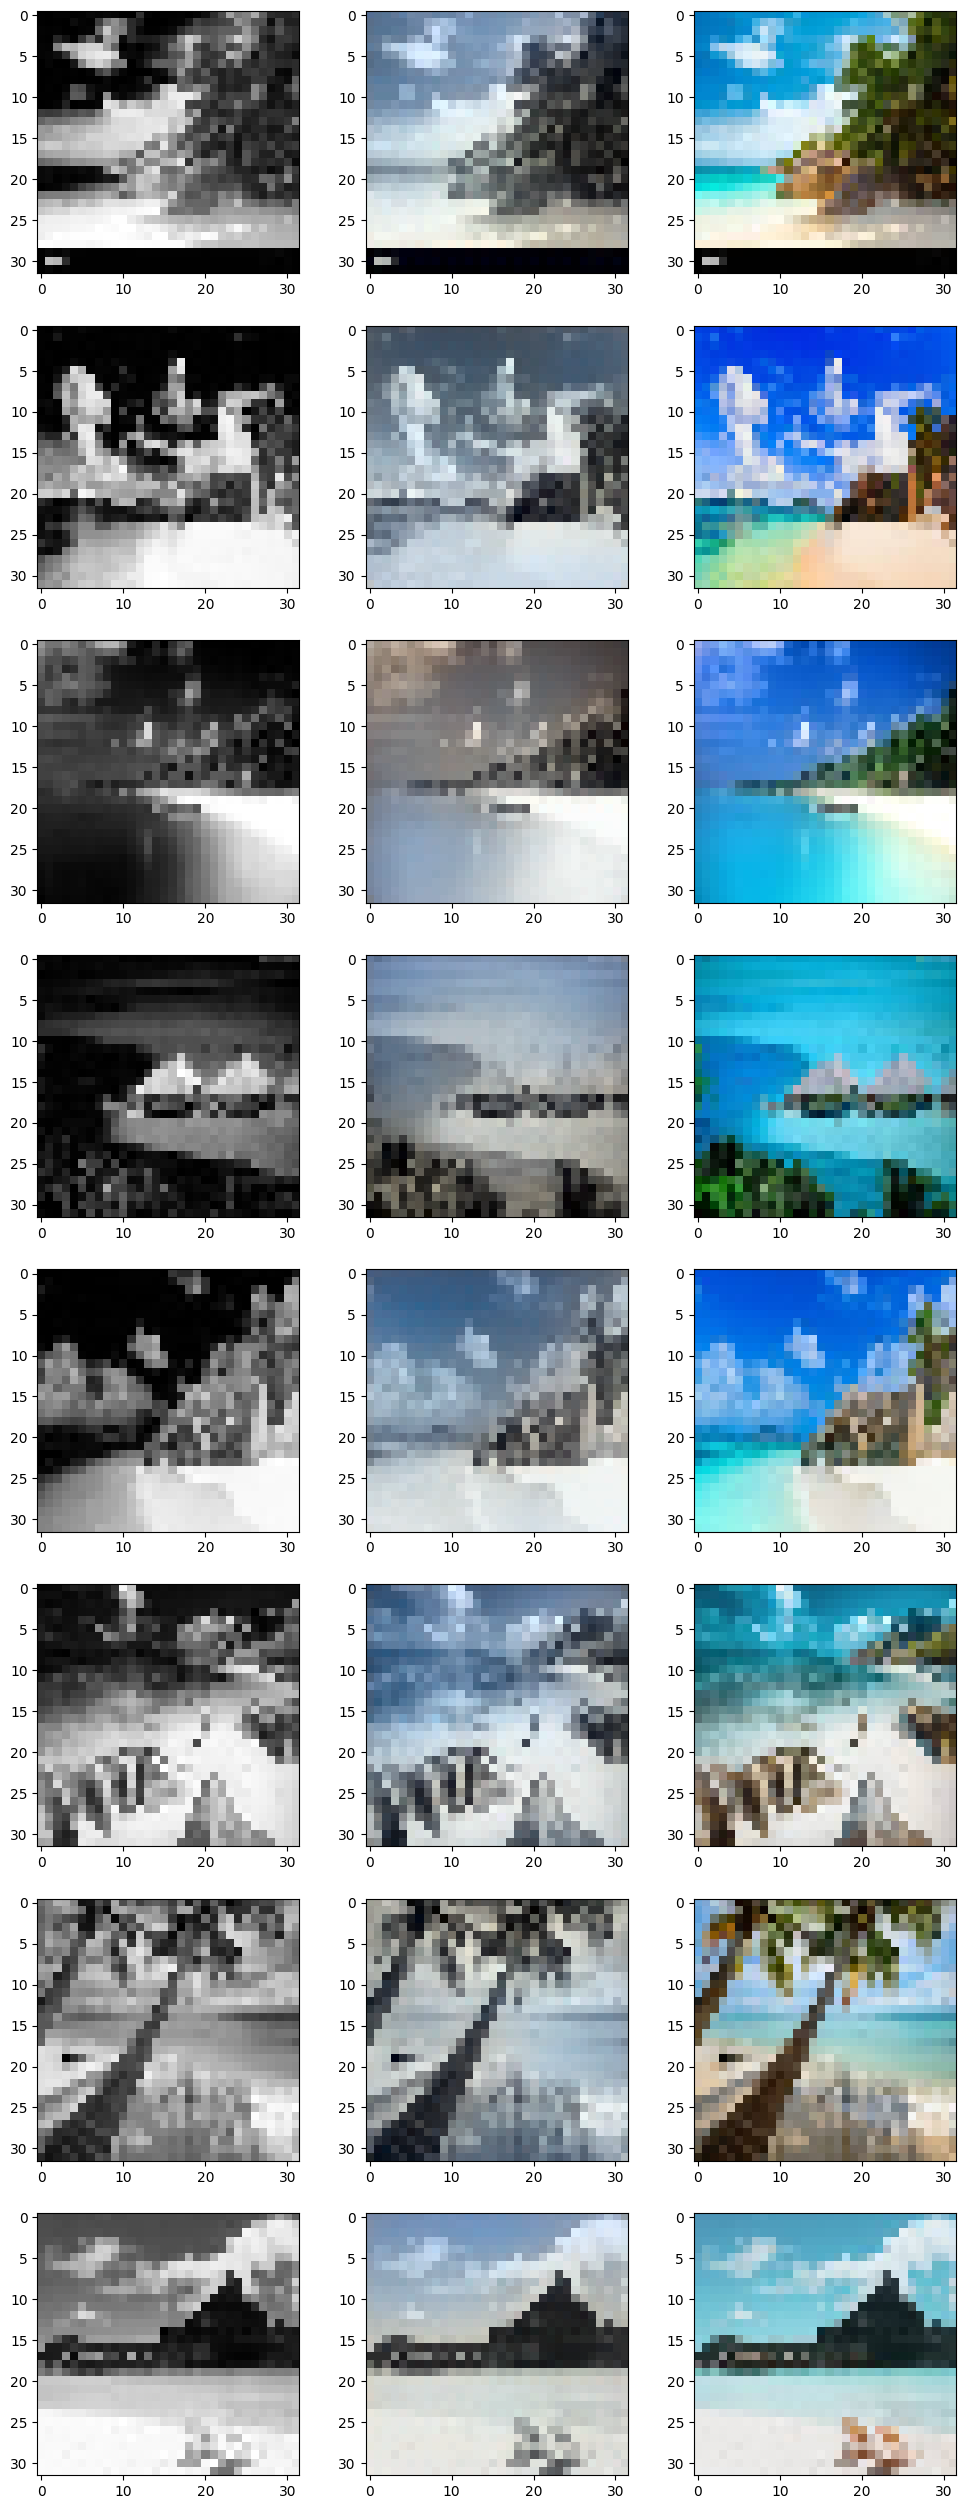

In [16]:
fig, ax = plt.subplots(8,3,figsize=(12,32))

for image_number in range(8):
    x, y = test_data_loader.load_processed_image_channels(image_number)
    x, y = x.to('cuda'), y.to('cuda')
    predictions = generator.colorize(x)
    ax[image_number][0].imshow(test_data_loader.load_unprocessed_image(
    image_number)[:,:,0], cmap='gray')
    
    ax[image_number][1].imshow(predictions.to('cpu').detach().numpy())
    
    ax[image_number][2].imshow(test_data_loader.load_unprocessed_image(image_number))

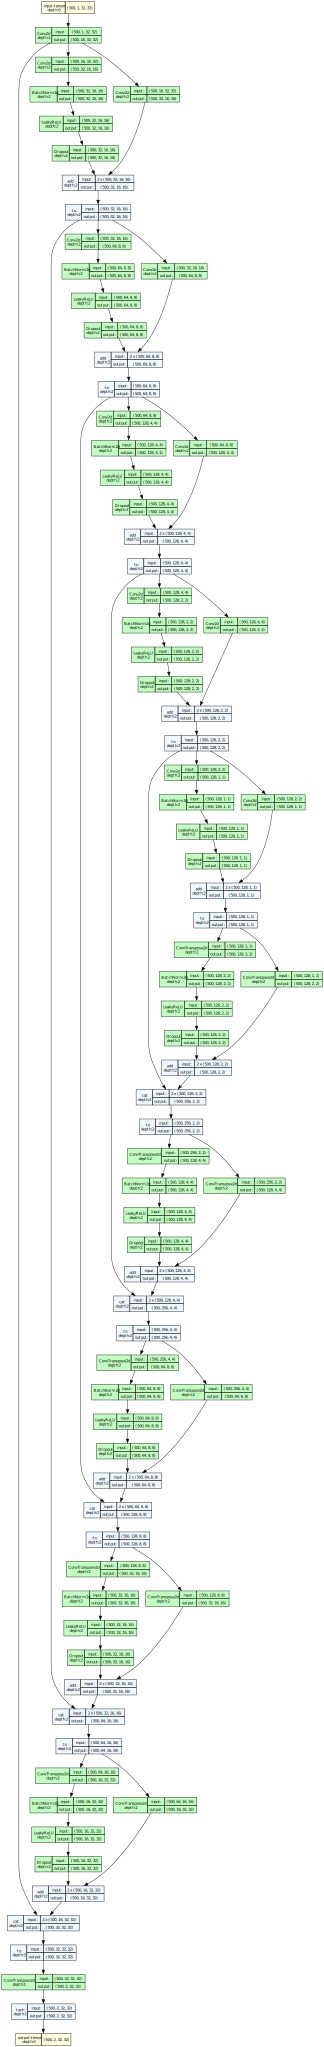

In [18]:
model_graph = draw_graph(generator, input_size=(h_batch_size, 1,h_image_size, h_image_size), device='cuda')
model_graph.visual_graph